**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Описание данных**

Данные лежат в файле /datasets/taxi.csv. 

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

**Цели**

Загрузить данные и выполнить их ресемплирование по одному часу.

Проанализировать данные.

Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

Проверить данные на тестовой выборке и сделать выводы.

## Загрузка данных

https://drive.google.com/file/d/1Xk3mROqnBfN6LPQk7kI6bebUQwhB6Voh/view?usp=sharing

In [ ]:
! gdown --id 1Xk3mROqnBfN6LPQk7kI6bebUQwhB6Voh

/bin/bash: gdown: command not found


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выводим значения float до 3 знаков после запятой
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
! pip install catboost
from catboost import CatBoostRegressor
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
print(statsmodels.__version__)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, GridSearchCV 

0.13.2


In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

**Вывод**

Загрузили данные, посмотрели и узнали, что в данных нет пропусков. Перейдем к анализу.

## Анализ

Проверим, расположены ли даты в хронологическом порядке.

In [ ]:
data.index.is_monotonic

True

In [ ]:
data = data.resample('1H').sum()

In [ ]:
decomposed = seasonal_decompose(data)

<AxesSubplot:title={'center':'Сезонность'}, xlabel='datetime'>

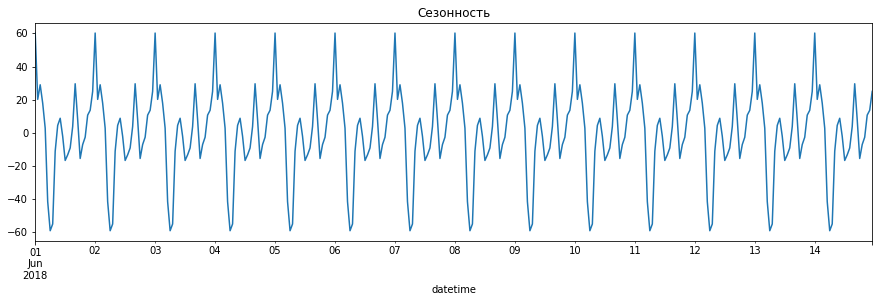

In [ ]:
decomposed.seasonal['2018-06-01':'2018-06-14'].plot(ax=plt.gca(), title='Сезонность', figsize=(15,4))

<AxesSubplot:xlabel='datetime'>

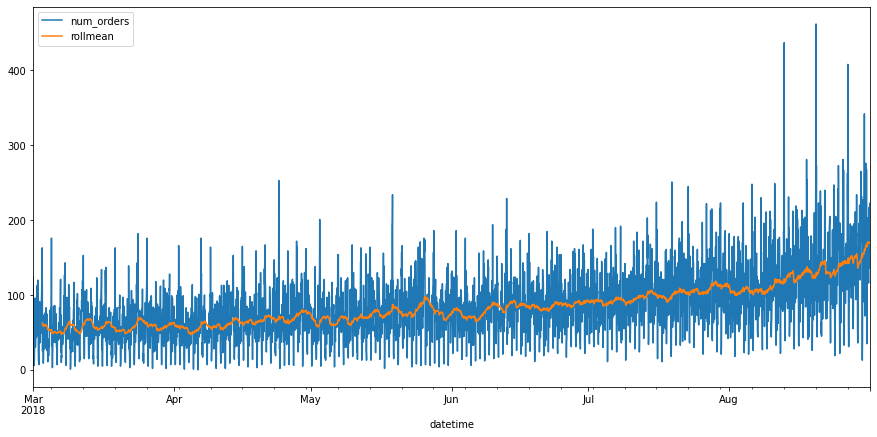

In [ ]:
data['rollmean']=data['num_orders'].rolling(50).mean()
data.plot(figsize=(15,7))

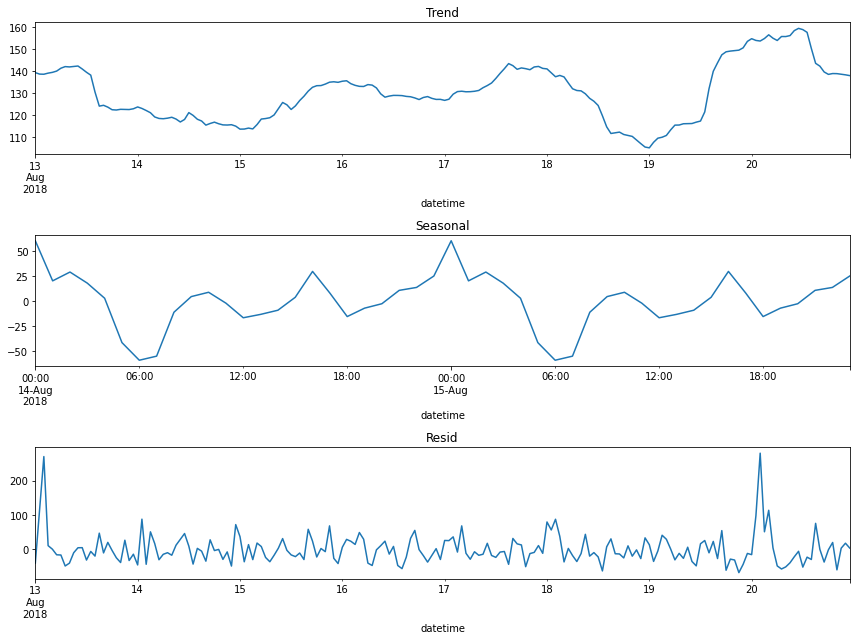

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplot(311)

decomposed.trend['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

**Вывод**

В данном шаге были проанализированы заказы, рассмотрены сезонность и тренды. Из графиков можно сделать выводы:

Общее количество заказов растет с каждым месяцем;

В течение дня количество заказов падает к утру, наименьшее количество можно наблюдать в 6 утра, а максимальное около 12 ночи.

## Обучение

Подготовим признаки, обучим модели.

In [ ]:
df = data.copy()
def make_features(df, max_lag, rolling_mean_size):
    
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['Year']=df.index.year
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [ ]:
df

,num_orders,rollmean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,169.180
2018-08-31 20:00:00,154,169.860
2018-08-31 21:00:00,159,169.660


In [ ]:
make_features(df, 24, 12)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4367 entries, 2018-03-03 01:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4367 non-null   int64  
 1   rollmean      4367 non-null   float64
 2   day           4367 non-null   int64  
 3   dayofweek     4367 non-null   int64  
 4   hour          4367 non-null   int64  
 5   Year          4367 non-null   int64  
 6   lag_1         4367 non-null   float64
 7   lag_2         4367 non-null   float64
 8   lag_3         4367 non-null   float64
 9   lag_4         4367 non-null   float64
 10  lag_5         4367 non-null   float64
 11  lag_6         4367 non-null   float64
 12  lag_7         4367 non-null   float64
 13  lag_8         4367 non-null   float64
 14  lag_9         4367 non-null   float64
 15  lag_10        4367 non-null   float64
 16  lag_11        4367 non-null   float64
 17  lag_12        4367 non-null

In [ ]:
cat_column = ['hours', 'dayofweek', 'is_weekend'] # категориальные данные

In [ ]:
train,test = train_test_split(df, test_size=0.1, shuffle=False)

In [ ]:
def features_target_split(df,target):
    features = df.drop(target, axis=1)
    target = df[target]
    return features, target

In [ ]:
features_test, target_test = features_target_split(test,'num_orders')
features_train, target_train = features_target_split(train,'num_orders')

Разделили выборку на тестовую и обучающую и отделили целевой признак

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train.iloc[:, 3:])
features_train.iloc[:, 3:] = scaler.transform(features_train.iloc[:, 3:])
features_test.iloc[:, 3:] = scaler.transform(features_test.iloc[:, 3:])

In [ ]:
models_scors = pd.DataFrame(columns = ['model', 'rmse'])

In [ ]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

### Линейная регрессия

In [ ]:
tscv = TimeSeriesSplit(n_splits=8)

%%time
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
grid.fit(features_train, target_train)
print("RMSE линейной регрессии составляет ", -grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_

**RMSE линейной регрессии составляет  26.453119904693345**

**Наилучшие подобранные параметры для линейной регрессии**

**CPU times: user 2.83 s, sys: 3.53 s, total: 6.36 s**

**Wall time: 6.38 s**

### LGBMRegressor

gbm = LGBMRegressor(random_state=12345)
    
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = RandomizedSearchCV(gbm, g_params,
                         cv=tscv, verbose=5, scoring=scorer)

g_grid.fit(features_train, target_train)

print("RMSE для LGBM составляет ", -g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)

**RMSE для LGBM составляет  24.303935280288222**

**Наилучшие подобранные параметры для LGBM**

**{'num_leaves': 41, 'n_estimators': 500, 'learning_rate': 0.01}**

### CatBoostRegressor

cbr = CatBoostRegressor(loss_function="RMSE")

grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}

cbr_grid = RandomizedSearchCV(cbr, grid,
                         cv=tscv, verbose=5, scoring=scorer)

cbr_grid.fit(features_train, target_train)

print("RMSE для CBR составляет ", -cbr_grid.best_score_)


print('Наилучшие подобранные параметры для CBR')
print(cbr_grid.best_params_)

**RMSE для CBR составляет  23.65684057713552**

**Наилучшие подобранные параметры для CBR**

**{'learning_rate': 0.1, 'iterations': 500}**

**Вывод**

Обучили модели: LinearRegression и LGBMRegressor и CatBoost. 

Наилучший результат показала модель CatBoost с полученным RMSE - 23,66

Результаты модели линейной регрессии: RMSE - 26,45, и результаты LightGBM: RMSE 24,30

## Тестирование

In [ ]:
models_scors

,model,rmse


Создадим таблицу для хранения результатов

In [ ]:
d = {'model': [], 'RMSE':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)

Функция, для добавления моделей в таблицу

In [ ]:
def model_res(model_name, model, features_train, target_train, features_test, target_test):
    rmse, fit_time, pred_time = ml(model, features_train, target_train, features_test, target_test)
    results.loc[len(results)] = [model_name, rmse, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [ ]:
def ml (model, features_train, target_train, features_test, target_test):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    rmse = mean_squared_error(target_test, predictions)**0.5
    
    return rmse, fit_time, pred_time

In [ ]:
def plot_test (model, model_name):
    plt.figure(figsize=(15,5))
    plt.title("Сравнение реальных значений и предсказанных с помощью модели " + model_name)
    plt.plot(target_test, label='Test values')
    predictions = model.predict(features_test)
    predictions = pd.Series(predictions, index=target_test.index)
    plt.plot(predictions, label ='Prediction values')
    plt.legend(loc="upper left")
    plt.grid(True)

### Линейная регрессия

,model,RMSE,fit_time,predict_time
0,LinearRegression,44.593,0.009,0.062


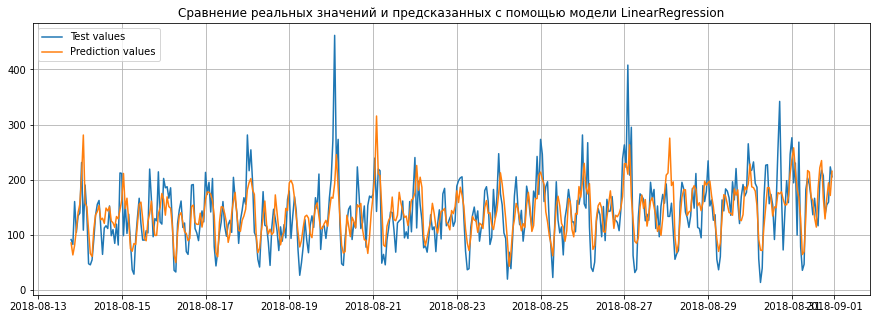

In [ ]:
lr = LinearRegression(fit_intercept=False, normalize=True)
model_res('LinearRegression', lr,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(lr, 'LinearRegression')

### LGBMRegressor

,model,RMSE,fit_time,predict_time
0,LinearRegression,44.593,0.009,0.062
1,LGBMRegressor,41.126,13.838,0.007


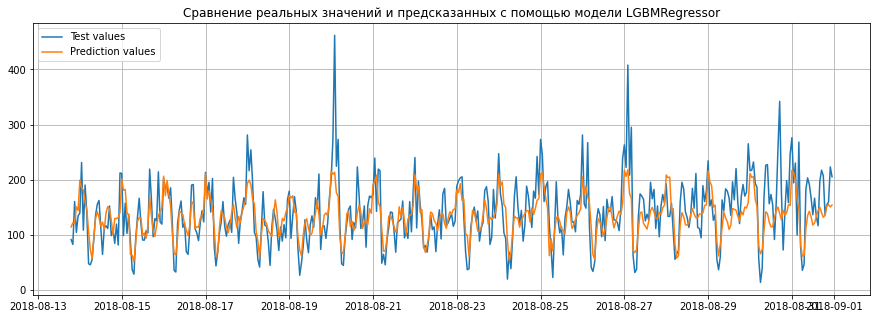

In [ ]:
lgbm = LGBMRegressor(learning_rate=0.01, n_estimators=500, num_leaves=41, random_state=12345)
model_res('LGBMRegressor', lgbm,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(lgbm, 'LGBMRegressor')

### CatBoostRegressor

0:	learn: 38.1867225	total: 59.6ms	remaining: 29.8s
1:	learn: 37.6002544	total: 68.8ms	remaining: 17.1s
2:	learn: 37.0520036	total: 78ms	remaining: 12.9s
3:	learn: 36.5349598	total: 87ms	remaining: 10.8s
4:	learn: 36.0830103	total: 95.5ms	remaining: 9.45s
5:	learn: 35.6263101	total: 104ms	remaining: 8.57s
6:	learn: 35.1731681	total: 113ms	remaining: 7.93s
7:	learn: 34.7354203	total: 121ms	remaining: 7.47s
8:	learn: 34.3263614	total: 130ms	remaining: 7.09s
9:	learn: 33.9412217	total: 139ms	remaining: 6.81s
10:	learn: 33.5713264	total: 148ms	remaining: 6.56s
11:	learn: 33.1654783	total: 157ms	remaining: 6.37s
12:	learn: 32.7868615	total: 165ms	remaining: 6.2s
13:	learn: 32.4183102	total: 174ms	remaining: 6.06s
14:	learn: 32.0808884	total: 184ms	remaining: 5.94s
15:	learn: 31.7737528	total: 192ms	remaining: 5.81s
16:	learn: 31.4754040	total: 201ms	remaining: 5.71s
17:	learn: 31.2134483	total: 209ms	remaining: 5.6s
18:	learn: 30.9396595	total: 218ms	remaining: 5.52s
19:	learn: 30.6681612	t

,model,RMSE,fit_time,predict_time
0,LinearRegression,44.593,0.009,0.062
1,LGBMRegressor,41.126,13.838,0.007
2,CatBoostRegressor,40.255,5.594,0.004


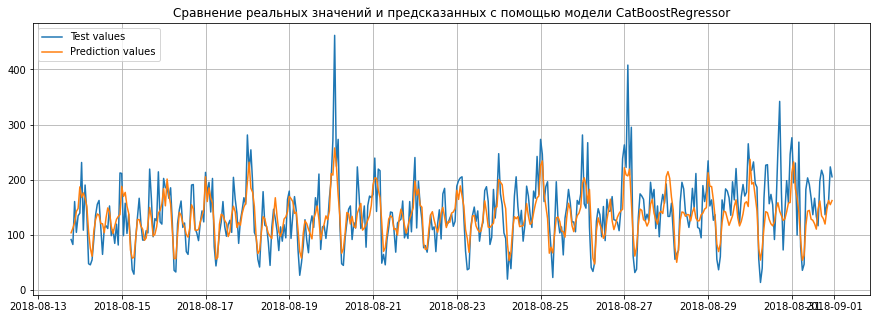

In [ ]:
cb = CatBoostRegressor(loss_function="RMSE",
                         learning_rate=0.03, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostRegressor', cb,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(cb, 'CatBoostRegressor')


**Вывод**

На тестовой выборке получили следующие значения RMSE:

In [ ]:
display(results)

,model,RMSE,fit_time,predict_time
0,LinearRegression,44.593,0.009,0.062
1,LGBMRegressor,41.126,13.838,0.007
2,CatBoostRegressor,40.255,5.594,0.004


# Общий вывод

Обучили модели: LinearRegression и LGBMRegressor и CatBoost. Наилучший результат показала модель CatBoost с полученным RMSE - 23,66.

На тестовой выборке результат модели RMSE CatBoost также показывает ллучший результат 40,3.